<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

# 2nd g2net training school - [CA17137](www.g2net.eu)
## CA17137 - A network for Gravitational Waves, Geophysics and Machine Learning

Acknowledgement: The materials for gravitational wave processing are borrowed and adopted from the
 [Gravitational Wave Open Data Workshop #2[(https://www.gw-openscience.org/s/workshop2/)


#### Discovering open data from GW observatories

This notebook describes how to discover what data are available from the [Gravitational-Wave Open Science Center (GWOSC)](https://www.gw-openscience.org).

## Querying for event information

The `gwosc.datasets` module provides tools to search for datasets, including filtering on GPS times.

For example, we can search for what event datasets are available:

In [4]:
from gwosc.datasets import find_datasets
events = find_datasets(type='event')
print(events)

['151008', '151012A', '151116', '161202', '161217', '170208', '170219', '170405', '170412', '170423', '170616', '170630', '170705', '170720', 'GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170817', 'GW170818', 'GW170823']


Here we see the list of confirmed detections (those prefixed as 'GW') and one likely detection (prefixed as 'LVT'). `find_datasets` also accepts a `detector` keyword to return only those datasets that include data for that detector.

We can query for the GPS time of a given event:

In [5]:
event_id='GW150914'
from gwosc.datasets import event_gps
gps = event_gps(event_id)
print(gps)

1126259462.4


<div class="alert alert-info">All of these times are returned in the GPS time system, which counts the number of seconds that have elapsed since the start of the GPS epoch at midnight (00:00) on January 6th 1980. LOSC provides a <a href="https://losc.ligo.org/gps/">GPS time converter</a> you can use to translate into datetime, or you can use <a href="https://gwpy.github.io/docs/stable/time/"><code>gwpy.time</code></a>.</div>

## Querying for data files

### Events during O1

The `gwosc.locate` module provides a function to find the URLs of data files associated with a given dataset.

For event datasets, one can get the list of URLs using only the event name:

[More information about LIGO's Dual Detectors](https://www.ligo.caltech.edu/WA/page/ligo-detectors).

![alt text](https://www.ligo.caltech.edu/system/media_files/binaries/180/large/LIGOs_Dual_Detectors.jpg?1431726608 "LIGO's Dual Detectors")



By default, the `get_event_urls` function returns all of the files associated with a given event, which isn't particularly helpful. However, we can can filter on any of these by using keyword arguments, for example to get the URL for the 32-second file for the LIGO-Livingston detector:

In [6]:
from gwosc.locate import get_event_urls
urls_L1 = get_event_urls(event_id, duration=32, detector='L1')
print(urls_L1)

['https://www.gw-osc.org/catalog/GWTC-1-confident/data/GW150914/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5']


The same thing for the Hanford's detector

In [7]:
urls_H1 = get_event_urls(event_id, duration=32, detector='H1')
print(urls_H1)

['https://www.gw-osc.org/catalog/GWTC-1-confident/data/GW150914/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5']


We could have chosen any of

- 'G1' - GEO600
- 'H1' - LIGO-Hanford
- 'L1' - LIGO-Livingston
- 'V1' - (Advanced) Virgo

In the future, the Japanese observatory KAGRA will come online, with the identifier 'K1'.

## Import some useful python modules so we can download the data

In [8]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json
import sys

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import os
import urllib


# -- Handy function to download data file, and return the filename
def download(url):
    filename = url.split('/')[-1]
    if not os.path.isfile(filename):
        print('Downloading ' + url )
        urllib.request.urlretrieve(url, filename)  
        print("File download complete")
    else:
        print("File already here")
    return filename

## Download an HDF5 data file

In [9]:
# -- Use the URL for a data file you found above
url=urls_H1[0]
filename_h = url.split('/')[-1]
download(url)


File already here


'H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5'

In [10]:
url = url=urls_L1[0]
filename_l = url.split('/')[-1]
download(url)


File already here


'L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5'

## Plot a short time series

In the code below:
1. Use the `readligo.loaddata()` method to load a time vector and strain vector from the data file
 1. *Hint: See how to use the `loaddata()` method here: https://losc.ligo.org/tutorial04/*
1. Plot strain as a function of time for 1000 samples 
 1. *Hint: Example code at bottom of https://losc.ligo.org/tutorial02/*

File already here


/Users/eftim/Repositories/MALTA-SP/readligo.py:155: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  shortnameArray = dqInfo['DQShortnames'].value
/Users/eftim/Repositories/MALTA-SP/readligo.py:161: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  injnameArray = injInfo['InjShortnames'].value
/Users/eftim/Repositories/MALTA-SP/readligo.py:166: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  gpsStart = meta['GPSstart'].value


Text(0, 0.5, 'H1 Strain')

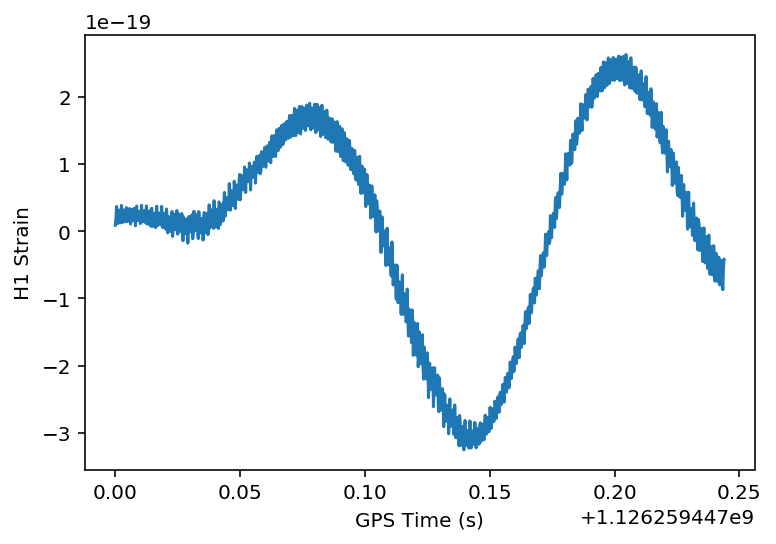

In [11]:
#%%

download('https://losc.ligo.org/s/sample_code/readligo.py')
import readligo as rl

# -- Use the loaddata() method here to load strain data
strain_h, time, dq = rl.loaddata(filename_h, 'H1')

# -- Plot the first 1000 samples of strain vs. time here
numSamples = 1000
plt.plot(time[0:numSamples], strain_h[0:numSamples])
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')


Text(0, 0.5, 'L1 Strain')

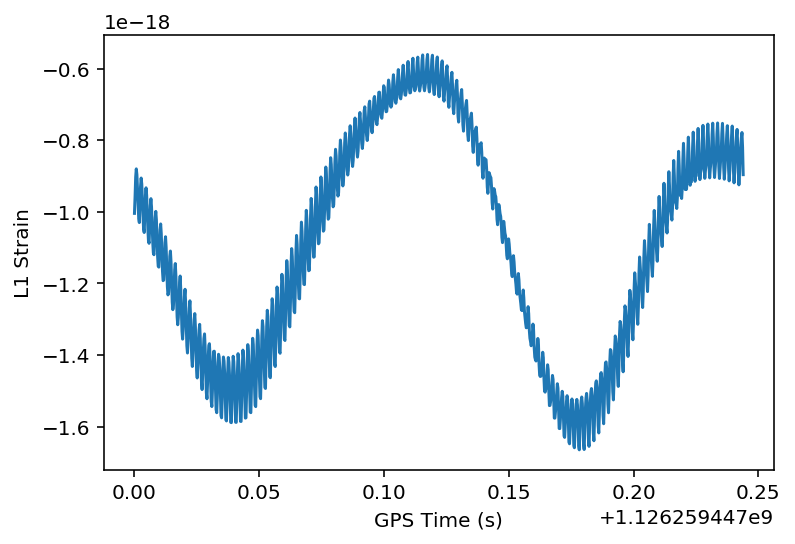

In [12]:
# -- Use the loaddata() method here to load strain data
strain_l, time, dq = rl.loaddata(filename_l, 'L1')

# -- Plot the first 1000 samples of strain vs. time here
numSamples = 1000
plt.plot(time[0:numSamples], strain_l[0:numSamples])
plt.xlabel('GPS Time (s)')
plt.ylabel('L1 Strain')

In [13]:
strain_l.shape

(131072,)

In [14]:
import pandas as pd
df = pd.DataFrame(index=time)
df.index.name='gps_time'
df['L1']=strain_l
df['H1']=strain_h
df.head()


L1            H1
gps_time                                
1.126259e+09 -1.004326e-18  9.067309e-21
1.126259e+09 -9.581150e-19  2.011789e-20
1.126259e+09 -9.030594e-19  3.712905e-20
1.126259e+09 -8.800127e-19  2.090712e-20
1.126259e+09 -8.962525e-19  1.159864e-20

In [15]:
filename_csv=filename_l.replace('L-L1_','').replace('.hdf5','.csv')
if not os.path.isfile(filename_csv):
    df.to_csv(filename_csv,header=True,index=True,sep=',')

### Let's do some plotting with plotly

In [16]:
# import chart_studio.plotly as py
import cufflinks as cf
import plotly.figure_factory as ff
#importing plotly and cufflinks in offline mode
import plotly.offline as py
cf.go_offline()
cf.set_config_file(offline=True, world_readable=True)
from dataframe_plot import generate_scatter_plot

In [17]:
filename_html=filename_csv.replace('.csv','.html')
generate_scatter_plot(df, df.columns, filename_html, mode='lines')

In [18]:
df.corr().iplot(kind='heatmap',colorscale="Blues", title="Channel Correlation Matrix")

Looks like the data between the two interferometers isn't correlated. Or so it seems...

# The Discrete Fourier Transform
<p>Let's consider a digital signal <span class="math">\(x\)</span> represented by a vector <span class="math">\((x_0, ..., x_{N-1})\)</span>. We assume that this signal is regularly sampled. The <strong>Discrete Fourier Transform (DFT)</strong> of <span class="math">\(x\)</span> is <span class="math">\(X = (X_0, ..., X_{N-1})\)</span> defined as:</p>
<div class="math">$$\forall k \in \{0, \ldots, N-1\}, \quad X_k = \sum_{n=0}^{N-1} x_n e^{-2i\pi kn/N}.$$</div>
<p>The DFT can be computed efficiently with the Fast Fourier Transform (FFT), an algorithm that exploits symmetries and redundancies in this definition to considerably speed up the computation. The complexity of the FFT is <span class="math">\(O(N \log N)\)</span> instead of <span class="math">\(O(N^2)\)</span> for the naive DFT. The FFT is one of the most important algorithms of the digital universe.</p>
<p>Here is an intuitive explanation of what the DFT describes. Instead of representing our signal on a real line, let's represent it on a circle. We can play the whole signal by making 1, 2, or any number <span class="math">\(k\)</span> of laps on the circle. Therefore, when <span class="math">\(k\)</span> is fixed, we represent each value <span class="math">\(x_n\)</span> of the signal with an angle <span class="math">\(2\pi kn / N\)</span> and a distance from the original equal to <span class="math">\(x_n\)</span>.</p>
<p>In the following figure, the signal is a sine wave at the frequency <span class="math">\(f=3 Hz\)</span>. The points of this signal are in blue, positioned at an angle <span class="math">\(2\pi kn / N\)</span>. Their algebraic sum in the complex plane is in red. These vectors represent the different coefficients of the signal's DFT.</p>



<p><img alt="Illustration of the DFT." src="https://ipython-books.github.io/pages/chapter10_signal/01_fourier_files/fourier.png" width="600"/></p>

<p>The next figure represents the previous signal's power spectral density (PSD):</p>
<p><img alt="The PSD of the signal in the previous example." src="https://ipython-books.github.io/pages/chapter10_signal/01_fourier_files/fourier_bis.png" width="400"/></p>
<h3>Inverse Fourier Transform</h3>
<p>By considering all possible frequencies, we have an exact representation of our digital signal in the frequency domain. We can recover the initial signal with an <strong>Inverse Fast Fourier Transform</strong> that computes an <strong>Inverse Discrete Fourier Transform</strong>. The formula is very similar to the DFT:</p>
<div class="math">$$\forall k \in \{0, \ldots, N-1\}, \quad x_k = \frac{1}{N} \sum_{n=0}^{N-1} X_n e^{2i\pi kn/N}.$$</div>
<p>The DFT is useful when periodic patterns are to be found. However, generally speaking, the Fourier transform cannot detect <em>transient</em> changes at specific frequencies. Local spectral methods are required, such as the <strong>wavelet transform</strong>.</p>
<h2>There's more...</h2>
<p>The following links contain more details about Fourier transforms:</p>
<ul>
<li>Introduction to the FFT with SciPy, available at <a href="http://scipy-lectures.github.io/intro/scipy.html#fast-fourier-transforms-scipy-fftpack">http://scipy-lectures.github.io/intro/scipy.html#fast-fourier-transforms-scipy-fftpack</a></li>
<li>Reference documentation for the fftpack in SciPy, available at <a href="http://docs.scipy.org/doc/scipy/reference/fftpack.html">http://docs.scipy.org/doc/scipy/reference/fftpack.html</a></li>
<li>Fourier Transform on Wikipedia, available at <a href="https://en.wikipedia.org/wiki/Fourier_transform">https://en.wikipedia.org/wiki/Fourier_transform</a></li>
<li>Discrete Fourier Transform on Wikipedia, available at <a href="https://en.wikipedia.org/wiki/Discrete_Fourier_transform">https://en.wikipedia.org/wiki/Discrete_Fourier_transform</a></li>
<li>Fast Fourier Transform on Wikipedia, available at <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform">https://en.wikipedia.org/wiki/Fast_Fourier_transform</a></li>
<li>Decibel on Wikipedia, available at <a href="https://en.wikipedia.org/wiki/Decibel">https://en.wikipedia.org/wiki/Decibel</a></li>
</ul>

## Handling data in the frequency domain using the Fourier transform

The [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) is a widely-used mathematical tool to expose the frequency-domain content of a time-domain signal, meaning we can see which frequencies contian lots of power, and which have less.

We can calculate the Fourier transform of our `TimeSeries` using the [`fft()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.fft) method:


In [19]:
from gwosc.datasets import event_gps
gps = event_gps(event_id)
frequency_strain = 1./4096
print(gps)

1126259462.4


In [20]:
print("We have data around the event:",event_id, gps-time[0], time[-1]-gps)

We have data around the event: GW150914 15.400000095367432 16.59975576400757


In [21]:
segment = (int(gps)-5, int(gps)+5)
print(segment)

(1126259457, 1126259467)


### Let's do the FFT with GWPy's functions

In [22]:
from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)
print(hdata)

Fetched 1 URLs from www.gw-osc.org for [1126259457 .. 1126259467))
Reading data... [Done]
TimeSeries([-3.37408113e-19, -3.60538427e-19, -3.22327735e-19,
            ...,  1.52206625e-19,  1.58897479e-19,
             1.71197631e-19]
           unit: dimensionless,
           t0: 1126259457.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


The verbose=True flag lets us see that GWpy has discovered two files that provides the data for the given interval, downloaded them, and loaded the data. The files are not stored permanently, so next time you do the same call, it will be downloaded again, however, if you know you might repeat the same call many times, you can use cache=True to store the file on your computer.

Notes:

To read data from a local file instead of from the GWOSC server, we can use TimeSeries.read method.
We have now downloaded real LIGO data for GW170817! These are the actual data used in the analysis that discovered the first binary neutron star merger.

To sanity check things, we can easily make a plot, using the plot() method of the data TimeSeries.

In [23]:
fft = hdata.fft()
print(fft)

FrequencySeries([ 2.83592039e-21+0.00000000e+00j,
                 -1.72531983e-20+9.11145513e-21j,
                  1.55498401e-20-6.38067019e-21j, ...,
                 -1.14703105e-23-7.91379036e-26j,
                 -1.15218693e-23+8.39374010e-28j,
                 -1.15216273e-23+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1126259457.0,
                name: Strain,
                channel: None)


Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD.

The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data.

They are an estimate of the "strain-equivalent noise" of the detectors versus frequency, which limit the ability of the detectors to identify GW signals.

They are in units of strain/rt(Hz). So, if you want to know the root-mean-square (rms) strain noise in a frequency band, integrate (sum) the squares of the ASD over that band, then take the square-root.

There's a signal in these data! For the moment, let's ignore that, and assume it's all noise.

The result is a FrequencySeries, with complex amplitude, representing the amplitude and phase of each frequency in our data. We can use abs() to extract the amplitude and plot that:

/usr/local/lib/python3.7/site-packages/gwpy/plot/plot.py:281: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



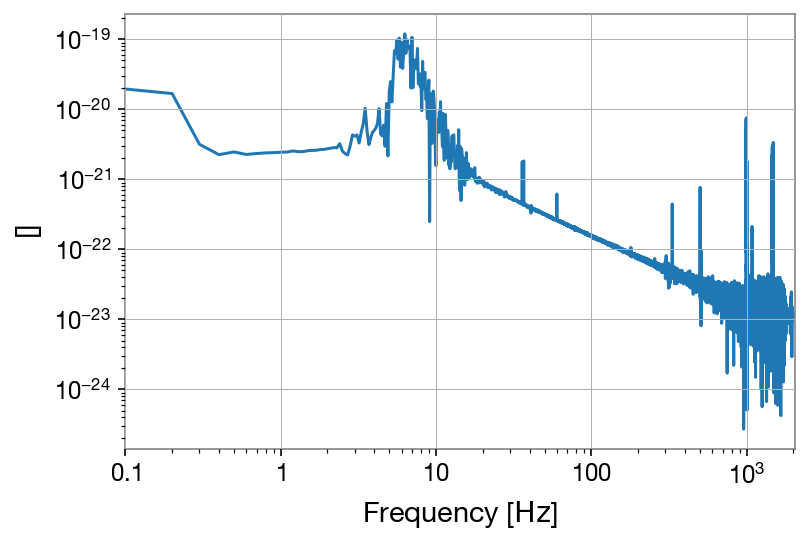

In [24]:
fft_abs=fft.abs()
plot = fft_abs.plot(xscale="log", yscale="log")
plot.show()

### Let's make the plot more interactive

In [25]:
def plot_FrequencySeries(list_fft_series):
    # https://gwpy.github.io/docs/stable/api/gwpy.frequencyseries.FrequencySeries.html
    if not isinstance(list_fft_series, list):
        list_fft_series=[list_fft_series]
    x = list_fft_series[0].frequencies
    df=pd.DataFrame(index=x)
    df.index.name='Frequency [Hz]'
    for i, fft_series in enumerate(list_fft_series):
        y=fft_series.value
        df[str(i)]=y
    df.iplot(kind='scatter', xaxis_type="log", yaxis_type="log")

In [26]:
plot_FrequencySeries(fft_abs)

This doesn't look correct at all! The problem is that the FFT works under the assumption that our data are periodic, which means that the edges of our data look like discontinuities when transformed.

We need to apply a window function to our time-domain data before transforming, which we can do using the scipy.signal module.

Windowing minimizes the calculations necessary to implement windowing of fast fourier transform (FFT) input data to reduce spectral leakage.

There are times when we need the FFT of unwindowed time domain data, while at the same time we also want the FFT of that same time-domain data with a window function applied.

[More about windowing](https://www.embedded.com/dsp-tricks-frequency-domain-windowing/).

In [27]:
from scipy.signal import get_window
window = get_window('hann', hdata.size)
hwin = hdata * window

In [28]:
print('Data shape:', hdata.shape, 'Window shape:', window.shape)

Data shape: (40960,) Window shape: (40960,)


Let's try our transform again and see what we get

In [29]:
fftamp = hwin.fft().abs()
# plot = fftamp.plot(xscale="log", yscale="log")
# plot.show()
plot_FrequencySeries(fftamp)

This looks a little more like what we expect for the amplitude spectral density of a gravitational-wave detector.

## Calculating the Power Spectral Density

In practice, we typically use a large number of FFTs to estimate an **averages power spectral density** over a long period of data.
We can do this using the [`asd()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.asd) method, which uses [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method) to combine FFTs of overlapping, windowed chunks of data.

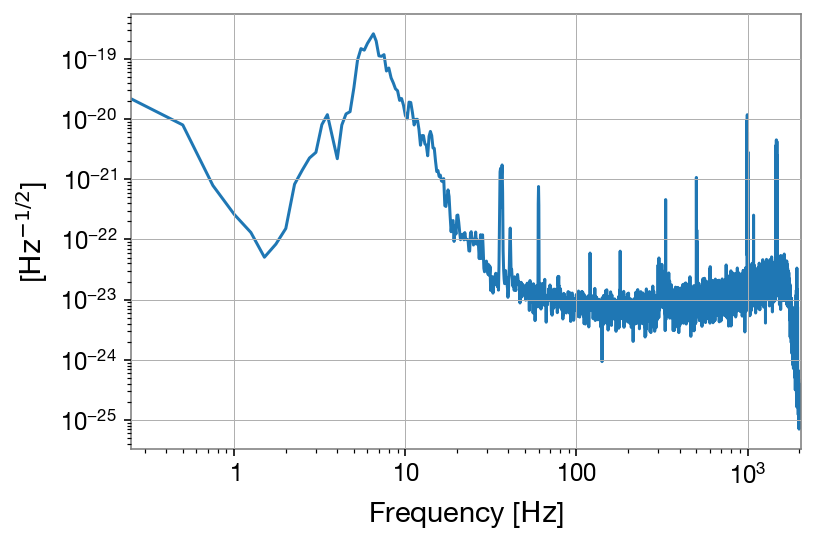

In [30]:
asd = hdata.asd(fftlength=4, method="median")
plot = asd.plot()
plot.show()

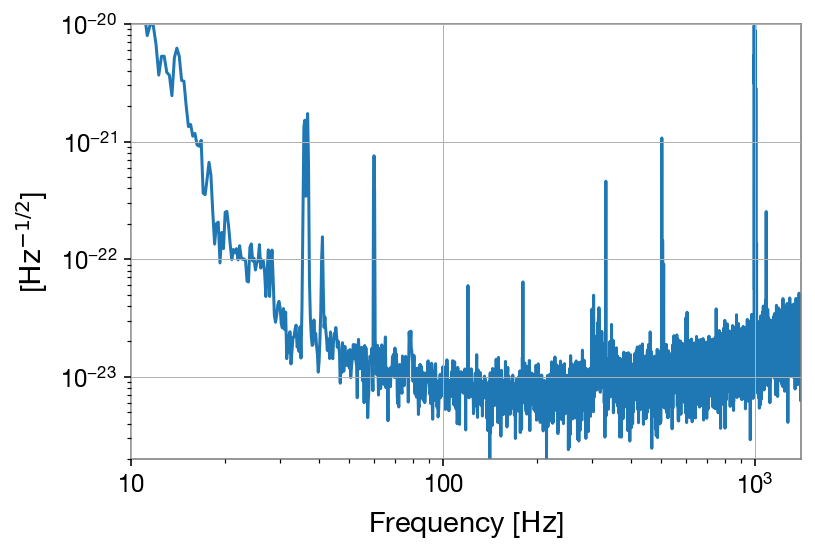

In [31]:
## zoom in on the x axis and y axis to focus on the more dense part
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(2e-24, 1e-20)
plot

Or use the interactive plot to look at this

In [32]:
plot_FrequencySeries(asd)

The ASD is a standard tool used to study the frequency-domain sensitivity of a gravitational-wave detector.
For the LIGO-Hanford data we loaded, we can see large spikes at certain frequencies, including

- ~300 Hz
- ~500 Hz
- ~1000 Hz

The [O2 spectral lines](https://www.gw-openscience.org/o2speclines/) page on GWOSC describes a number of these spectral features for O2, with some of them being forced upon us, and some being deliberately introduced to help with interferometer control.

Loading more data allows for more FFTs to be averaged during the ASD calculation, meaning random variations get averaged out, and we can see more detail:

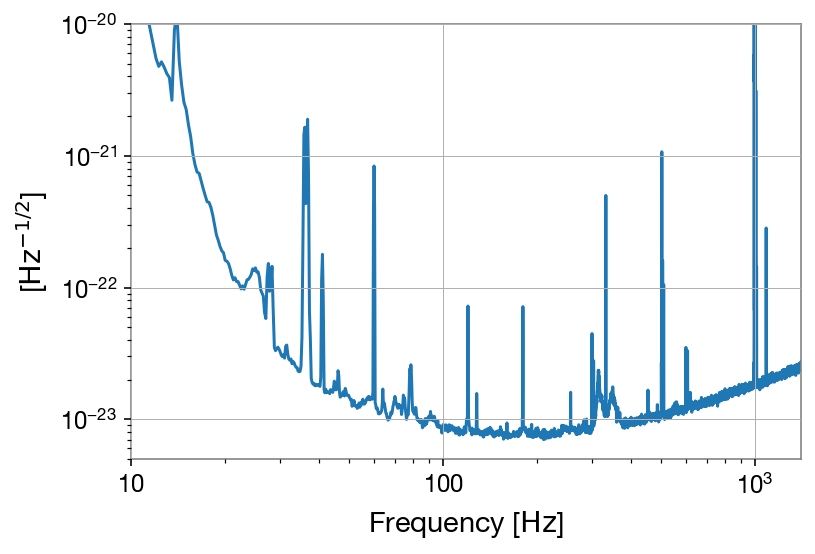

In [33]:
hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(gps)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method="median")
plot = hasd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(5e-24, 1e-20)
plot.show()

In [34]:
plot_FrequencySeries(hasd2)

Now we can see some more features, including sets of lines around ~30 Hz and ~65 Hz, and some more isolate lines through the more sensitive region.

For comparison, we can load the LIGO-Livingston data and plot that as well:

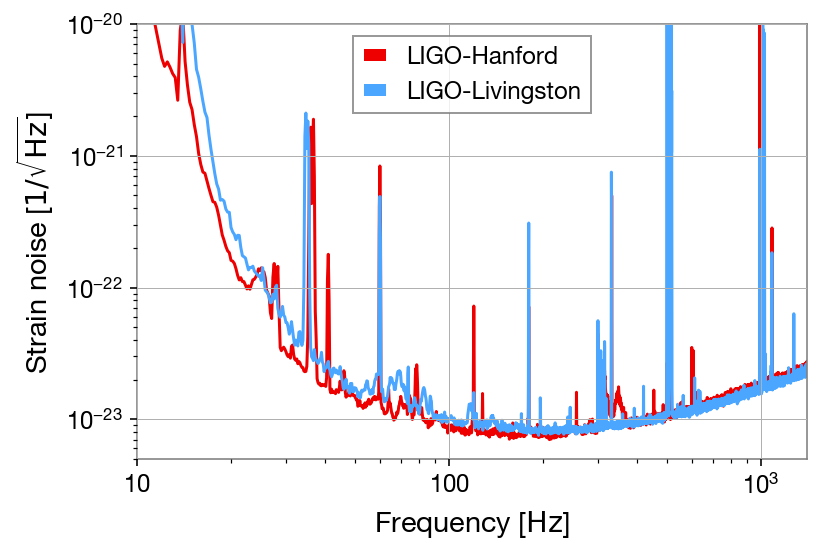

In [35]:
# get Livingston data
ldata2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(lasd2, label='LIGO-Livingston', color='gwpy:ligo-livingston')

# update the Hanford line to use standard colour, and have a label
hline = ax.lines[0]
hline.set_color('gwpy:ligo-hanford')  # change colour of Hanford data
hline.set_label('LIGO-Hanford')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

In [36]:
x = lasd2.frequencies
df=pd.DataFrame(index=x)
df.index.name='Frequency [Hz]'
df['LIGO-Handfort'] = hasd2.value
df['LIGO-Livingston'] = lasd2.value

df.iplot(kind='scatter', xaxis_type="log", yaxis_type="log", yaxis_title=r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]', xaxis_title=r'Frequency [Hz]')
# plot_FrequencySeries([hasd2, lasd2])

Now we can see clearly the relative sensitivity of each LIGO instrument, the common features between both, and those unique to each observatory.

Remember the cross-correlation chart saying the data is so different? Not so different after all...

In [37]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
 %reload_ext autoreload

### Read the event properties from a local json file (download in advance)

In [39]:
# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[event_id]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()

# TODO: show filtered time-domain data

## Moving averages
## Band filter
## Correlation matrix after the smoothing/filtering

In [40]:
# Extract the parameters for the desired event:
event = events[event_id]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

Reading in parameters for event GW150914
{'name': 'GW150914', 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5', 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5', 'fn_template': 'GW150914_4_template.hdf5', 'fs': 4096, 'tevent': 1126259462.44, 'utcevent': '2015-09-14T09:50:45.44', 'm1': 41.743, 'm2': 29.237, 'a1': 0.355, 'a2': -0.769, 'approx': 'lalsim.SEOBNRv2', 'fband': [43.0, 300.0], 'f_min': 10.0}


In [41]:
from scipy.signal import butter, lfilter
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

#### Let's keep a dataframe with the original signal and the filtered versions of it

In [61]:
df_fil = pd.DataFrame(index=time)
df_fil.index.name='gps_time'
df_fil['L1']=strain_l
df_fil['H1']=strain_h

### Simple Moving Average Filtering (Running Mean)

More applications here:
- https://gordoncluster.wordpress.com/2014/02/13/python-numpy-how-to-generate-moving-averages-efficiently-part-2/
- https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788
- https://stackoverflow.com/questions/13728392/moving-average-or-running-mean


In [72]:
import numpy as np
from numpy import convolve
 
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    sma = sma.tolist()+[values[0]]*(window-1)
    return sma

df_fil['L1']=strain_l

for ord in [5,10,15]:
    strain_l_mva = movingaverage(strain_l, window=ord)
    strain_h_mva = movingaverage(strain_h, window=ord)
    df_fil['L1_mva_'+str(ord)]=strain_l_mva
    df_fil['H1_mva_'+str(ord)]=strain_h_mva


In [71]:
generate_scatter_plot(df_fil, df_fil.columns, filename_html, mode='lines')

### Band Filtering

Applying the band filter for different orders. [More about Butterworth Bandpass](https://www.electronics-tutorials.ws/filter/filter_8.html)

In [42]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [55]:
lowcut, highcut = fband
print('Base frequency', fs, 'Band frequency will be applied. Retaining singal between in the range:',lowcut, highcut, 'Hz')

Base frequency 4096 Band frequency will be applied. Retaining singal between in the range: 43.0 300.0 Hz


In [62]:
for ord in [3,4,5]:
    strain_l_filtered = butter_bandpass_filter(strain_l, lowcut, highcut, fs, order=ord)
    strain_h_filtered = butter_bandpass_filter(strain_h, lowcut, highcut, fs, order=ord)
    df_fil['L1_band_'+str(ord)]=strain_l_filtered
    df_fil['H1_band_'+str(ord)]=strain_h_filtered

In [63]:
generate_scatter_plot(df_fil, df_fil.columns, filename_html, mode='lines')